In [20]:
import os 
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras import layers, models, optimizers 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from PIL import Image 
import matplotlib.pyplot as plt 
import time
from sklearn.utils.class_weight import compute_class_weight


In [21]:
# Set paths based on your Kaggle dataset structure
base_dir = '/kaggle/input/soil-classification/soil_classification-2025'  # Adjust this path
train_dir = os.path.join(base_dir, 'train') 
test_dir = os.path.join(base_dir, 'test') 

# Check if the paths exist 
print(f"Train directory exists: {os.path.exists(train_dir)}") 
print(f"Test directory exists: {os.path.exists(test_dir)}")

# If you have CSV files with labels
train_csv = os.path.join(base_dir, 'train_labels.csv') 
test_csv = os.path.join(base_dir, 'test_ids.csv')
print(f"Train CSV exists: {os.path.exists(train_csv)}") 
print(f"Test CSV exists: {os.path.exists(test_csv)}")


Train directory exists: True
Test directory exists: True
Train CSV exists: True
Test CSV exists: True


In [22]:
# Include all common image formats 
valid_image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif', '.webp') 

def find_corrupted_images(directory): 
    corrupted_images = [] 
    if not os.path.exists(directory): 
        print(f"Directory not found: {directory}") 
        return corrupted_images 

    for filename in os.listdir(directory): 
        if filename.lower().endswith(valid_image_extensions): 
            file_path = os.path.join(directory, filename) 
            try: 
                with Image.open(file_path) as img: 
                    img.verify()  # Verify the image 
            except (IOError, SyntaxError, OSError) as e: 
                print(f"Corrupted image found: {file_path} - {e}") 
                corrupted_images.append(filename) 
    return corrupted_images 

# Function to find invalid files
def find_invalid_files(df, column, directory):
    invalid_files = []
    for filename in df[column]:
        file_path = os.path.join(directory, filename)
        if not os.path.exists(file_path):
            invalid_files.append(filename)
    return invalid_files


In [23]:
print("Checking for corrupted images in training set...") 
corrupted_train = find_corrupted_images(train_dir) 
print(f"Found {len(corrupted_train)} corrupted images in training set")


Checking for corrupted images in training set...
Found 0 corrupted images in training set


In [24]:
# This code handles both CSV-based and directory-based datasets
try: 
    # Try to load from CSV files if they exist
    train_df = pd.read_csv(train_csv) 
    test_df = pd.read_csv(test_csv) 
    
    print("Train CSV columns:", train_df.columns.tolist()) 
    print("Test CSV columns:", test_df.columns.tolist()) 
    
    # Rename columns if needed 
    if 'image_id' not in train_df.columns: 
        # Try to find the column containing image filenames 
        for col in train_df.columns: 
            if train_df[col].dtype == 'object' and train_df[col].str.contains(r'\.(jpg|jpeg|png|gif|webp)$', case=False, regex=True).any(): 
                train_df = train_df.rename(columns={col: 'image_id'}) 
                print(f"Renamed column '{col}' to 'image_id'") 
                break 
    
    if 'soil_type' not in train_df.columns: 
        # Assume the non-image column is the label 
        for col in train_df.columns: 
            if col != 'image_id': 
                train_df = train_df.rename(columns={col: 'soil_type'}) 
                print(f"Renamed column '{col}' to 'soil_type'") 
                break 
    
    if 'image_id' not in test_df.columns:  # Try to find the column containing image filenames 
        for col in test_df.columns: 
            if test_df[col].dtype == 'object': 
                test_df = test_df.rename(columns={col: 'image_id'}) 
                print(f"Renamed column '{col}' to 'image_id'") 
                break 
    
    # Remove corrupted images from dataframe 
    if corrupted_train: 
        train_df = train_df[~train_df['image_id'].isin(corrupted_train)] 
        
    print("Class distribution in training set:") 
    print(train_df['soil_type'].value_counts()) 

except Exception as e: 
    print(f"Error loading CSV files: {e}") 
    # If CSV loading fails, try to create dataframes from directory structure 
    print("Creating dataframes from directory structure...") 
    
    # Create train dataframe from directory structure 
    train_images = [] 
    train_labels = [] 
    
    for label in os.listdir(train_dir): 
        label_dir = os.path.join(train_dir, label) 
        if os.path.isdir(label_dir): 
            for img in os.listdir(label_dir): 
                if img.lower().endswith(valid_image_extensions): 
                    train_images.append(img) 
                    train_labels.append(label) 
    
    train_df = pd.DataFrame({'image_id': train_images, 'soil_type': train_labels}) 
    
    # Create test dataframe from directory structure 
    test_images = [] 
    test_labels = []
    
    # For test set with labels
    for label in os.listdir(test_dir): 
        label_dir = os.path.join(test_dir, label) 
        if os.path.isdir(label_dir): 
            for img in os.listdir(label_dir): 
                if img.lower().endswith(valid_image_extensions): 
                    test_images.append(img) 
                    test_labels.append(label)
    
    # If test directory doesn't have subdirectories with labels
    if not test_images:
        test_images = [img for img in os.listdir(test_dir) if img.lower().endswith(valid_image_extensions)]
        test_df = pd.DataFrame({'image_id': test_images})
    else:
        test_df = pd.DataFrame({'image_id': test_images, 'soil_type': test_labels})
    
    print("Created dataframes from directory structure") 
    print("Class distribution in training set:") 
    print(train_df['soil_type'].value_counts())


Train CSV columns: ['image_id', 'soil_type']
Test CSV columns: ['image_id']
Class distribution in training set:
soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64


In [25]:
# Fix for invalid image filenames - convert to absolute paths
# For training data
abs_train_file_names = []
for file_name in train_df['image_id']:
    tmp = os.path.abspath(os.path.join(train_dir, file_name))
    abs_train_file_names.append(tmp)
train_df['image_id'] = abs_train_file_names

# For test data
abs_test_file_names = []
for file_name in test_df['image_id']:
    tmp = os.path.abspath(os.path.join(test_dir, file_name))
    abs_test_file_names.append(tmp)
test_df['image_id'] = abs_test_file_names

# Check for invalid files after converting to absolute paths
train_invalid = find_invalid_files(train_df, 'image_id', '')  # Empty directory since we're using absolute paths
test_invalid = find_invalid_files(test_df, 'image_id', '')
print(f"Invalid training files after path conversion: {len(train_invalid)}")
print(f"Invalid test files after path conversion: {len(test_invalid)}")

# Remove invalid files from dataframes if any
if train_invalid:
    train_df = train_df[~train_df['image_id'].isin(train_invalid)]
if test_invalid:
    test_df = test_df[~test_df['image_id'].isin(test_invalid)]


Invalid training files after path conversion: 0
Invalid test files after path conversion: 0


In [26]:
# Set image parameters 
IMG_SIZE = 224 
BATCH_SIZE = 32 

# Data augmentation for training 
train_datagen = ImageDataGenerator( 
    rescale=1./255, 
    validation_split=0.2,  # 20% for validation 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest' 
) 

# Only rescaling for validation and test data 
valid_datagen = ImageDataGenerator( 
    rescale=1./255, 
    validation_split=0.2 
) 

test_datagen = ImageDataGenerator(rescale=1./255) 


In [27]:
# Create data generators 
try: 
    # For training data - use directory=None since we're using absolute paths
    train_generator = train_datagen.flow_from_dataframe( 
        dataframe=train_df, 
        directory=None,  # Use None since we have absolute paths
        x_col="image_id", 
        y_col="soil_type", 
        target_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE, 
        class_mode='categorical', 
        subset='training',
        validate_filenames=False,  # Skip filename validation
        shuffle=True,  # Make sure to shuffle training data
        workers=4,
        use_multiprocessing=True,
        max_queue_size=10
    ) 
    
    # For validation data
    validation_generator = valid_datagen.flow_from_dataframe( 
        dataframe=train_df, 
        directory=None,  # Use None since we have absolute paths
        x_col="image_id", 
        y_col="soil_type", 
        target_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE, 
        class_mode='categorical', 
        subset='validation', 
        shuffle=False,
        validate_filenames=False,  # Skip filename validation
        workers=4,
        use_multiprocessing=True,
        max_queue_size=10
    ) 
    
    # For test data
    if 'soil_type' in test_df.columns:
        test_generator = test_datagen.flow_from_dataframe( 
            dataframe=test_df, 
            directory=None,  # Use None since we have absolute paths
            x_col="image_id", 
            y_col="soil_type", 
            target_size=(IMG_SIZE, IMG_SIZE), 
            batch_size=BATCH_SIZE, 
            class_mode='categorical', 
            shuffle=False,
            validate_filenames=False,  # Skip filename validation
            workers=4,
            use_multiprocessing=True,
            max_queue_size=10
        )
    else:
        test_generator = test_datagen.flow_from_dataframe( 
            dataframe=test_df, 
            directory=None,  # Use None since we have absolute paths
            x_col="image_id", 
            y_col=None, 
            target_size=(IMG_SIZE, IMG_SIZE), 
            batch_size=BATCH_SIZE, 
            class_mode=None, 
            shuffle=False,
            validate_filenames=False,  # Skip filename validation
            workers=4,
            use_multiprocessing=True,
            max_queue_size=10
        )
    
    # Print generator information
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {validation_generator.samples}")
    print(f"Number of classes: {train_generator.num_classes}")
    print(f"Class indices: {train_generator.class_indices}")
    
    # Check validation data distribution more safely
    print("Validation data class distribution:")
    # Use a smaller sample to check distribution without exhausting the generator
    val_sample_batches = min(3, len(validation_generator))  # Check only first 3 batches
    val_labels_sample = []
    
    for i in range(val_sample_batches):
        batch_x, batch_y = next(validation_generator)
        val_labels_sample.extend(np.argmax(batch_y, axis=1))
    
    for class_idx, count in zip(*np.unique(val_labels_sample, return_counts=True)):
        class_name = [k for k, v in train_generator.class_indices.items() if v == class_idx][0]
        print(f"Class {class_idx} ({class_name}): {count} samples (from sample)")
    
    validation_generator.reset()  # Reset after checking
    
    # Display a few training images to verify
    batch_x, batch_y = next(train_generator) 
    plt.figure(figsize=(10, 10)) 
    for i in range(min(9, len(batch_x))): 
        plt.subplot(3, 3, i+1) 
        plt.imshow(batch_x[i]) 
        class_idx = np.argmax(batch_y[i])
        class_name = [k for k, v in train_generator.class_indices.items() if v == class_idx][0]
        plt.title(f"Class: {class_idx} ({class_name})") 
        plt.axis('off') 
    plt.tight_layout() 
    plt.show()
    
    # Reset training generator after visualization
    train_generator.reset()
    
except Exception as e: 
    print(f"Error creating data generators: {e}") 
    print("Attempting to create generators without multiprocessing...")
    
    # Fallback without multiprocessing
    try:
        train_generator = train_datagen.flow_from_dataframe( 
            dataframe=train_df, 
            directory=None,
            x_col="image_id", 
            y_col="soil_type", 
            target_size=(IMG_SIZE, IMG_SIZE), 
            batch_size=BATCH_SIZE, 
            class_mode='categorical', 
            subset='training',
            validate_filenames=False,
            shuffle=True
        ) 
        
        validation_generator = valid_datagen.flow_from_dataframe( 
            dataframe=train_df, 
            directory=None,
            x_col="image_id", 
            y_col="soil_type", 
            target_size=(IMG_SIZE, IMG_SIZE), 
            batch_size=BATCH_SIZE, 
            class_mode='categorical', 
            subset='validation', 
            shuffle=False,
            validate_filenames=False
        )
        
        print("Successfully created generators without multiprocessing")
        
    except Exception as e2:
        print(f"Fallback also failed: {e2}")
        raise


Found 978 non-validated image filenames belonging to 4 classes.
Found 244 non-validated image filenames belonging to 4 classes.
Found 341 non-validated image filenames.
Training samples: 978
Validation samples: 244
Error creating data generators: 'DataFrameIterator' object has no attribute 'num_classes'
Attempting to create generators without multiprocessing...
Found 978 non-validated image filenames belonging to 4 classes.
Found 244 non-validated image filenames belonging to 4 classes.
Successfully created generators without multiprocessing


In [28]:
# Get class weights to handle imbalanced data
class_weights = compute_class_weight( 
    class_weight='balanced', 
    classes=np.unique(train_df['soil_type']), 
    y=train_df['soil_type'] 
) 

# Convert to dictionary for Keras 
class_weight_dict = dict(zip(range(len(class_weights)), class_weights)) 
print("Class weights:", class_weight_dict)


Class weights: {0: 0.5785984848484849, 1: 1.3225108225108224, 2: 1.535175879396985, 3: 1.1571969696969697}


In [29]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([ 
    layers.RandomFlip('horizontal'), 
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.1), 
    layers.RandomContrast(0.1), 
]) 

def build_mobilenetv2_model(num_classes): 
    # Load model without pre-trained weights to avoid download issues
    base_model = MobileNetV2( 
        input_shape=(IMG_SIZE, IMG_SIZE, 3), 
        include_top=False, 
        weights=None  # Don't try to download weights
    ) 
    
    # Build the model architecture
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) 
    x = data_augmentation(inputs) 
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x) 
    x = base_model(x, training=True)  # Set training=True
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.BatchNormalization()(x)  # Add batch normalization
    x = layers.Dense(512, activation='relu', 
                    kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x) 
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x) 
    
    model = tf.keras.Model(inputs, outputs) 
    
    # Compile the model with learning rate schedule
    model.compile( 
        optimizer=optimizers.Adam(learning_rate=lr_schedule),  # Use the learning rate schedule
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy', 
            tf.keras.metrics.Precision(name='precision'), 
            tf.keras.metrics.Recall(name='recall'), 
            tf.keras.metrics.F1Score(average='weighted', name='f1_score')
        ] 
    ) 
    
    return model, base_model


# Alternative simpler model in case the above doesn't work
def build_simple_model(num_classes):
    model = tf.keras.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall(), 
                tf.keras.metrics.F1Score(average='weighted', name='f1_score')]
    )
    
    return model, model  # Return the same model twice to match existing code


In [30]:
# Get number of classes and build model
num_classes = len(train_df['soil_type'].unique()) 
print(f"Number of classes: {num_classes}")

# Try to build MobileNetV2 model, fall back to simple model if it fails
try:
    model, base_model = build_mobilenetv2_model(num_classes)
    print("Successfully created MobileNetV2 model")
except Exception as e:
    print(f"Error creating MobileNetV2 model: {e}")
    print("Falling back to simple CNN model")
    model, base_model = build_simple_model(num_classes)
    print("Successfully created simple CNN model")

model.summary()


Number of classes: 4
Error creating MobileNetV2 model: name 'lr_schedule' is not defined
Falling back to simple CNN model
Successfully created simple CNN model


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Calculate steps first
steps_per_epoch = len(train_generator)  # Use len() instead of samples//batch_size
validation_steps = len(validation_generator)  # Use len() instead of samples//batch_size

# Ensure steps are at least 1
steps_per_epoch = max(1, steps_per_epoch) 
validation_steps = max(1, validation_steps) 

print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

# Define learning rate schedule AFTER calculating steps_per_epoch
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=steps_per_epoch*3,
    decay_rate=0.5,
    staircase=True
)

# Define callbacks for training
callbacks = [ 
    EarlyStopping(monitor='val_f1_score', patience=7, mode='max', restore_best_weights=True), 
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001),
    tf.keras.callbacks.ModelCheckpoint(
        'best_soil_model.h5',
        monitor='val_f1_score',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]


Steps per epoch: 31, Validation steps: 8


In [32]:
# Start the timer before training 
start_time = time.time() 

# Train the model 
history = model.fit( 
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    validation_data=validation_generator, 
    validation_steps=validation_steps, 
    epochs=20,  # Increase epochs for better learning
    callbacks=callbacks, 
    class_weight=class_weight_dict,
    verbose=1,
    shuffle=True  # Ensure data is shuffled between epochs
) 

training_time = time.time() - start_time 
print(f"Training completed in {training_time/60:.2f} minutes")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4208 - f1_score: 0.4071 - loss: 1.6001 - precision_1: 0.5205 - recall_1: 0.2398
Epoch 1: val_f1_score improved from -inf to 0.78000, saving model to best_soil_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4245 - f1_score: 0.4112 - loss: 1.5857 - precision_1: 0.5257 - recall_1: 0.2438 - val_accuracy: 0.6393 - val_f1_score: 0.7800 - val_loss: 1.0882 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7311 - f1_score: 0.7328 - loss: 0.6326 - precision_1: 0.8106 - recall_1: 0.6168
Epoch 2: val_f1_score did not improve from 0.78000
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.7305 - f1_score: 0.7321 - loss: 0.6334 - precision_1: 0.8096 - recall_1: 0.6175 - val_accuracy: 0.6107 - val_f1_score: 0.7583 - val_loss: 0.9256 - val_precision_1: 0.6130 - val_recall_1: 0.5779 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━

In [33]:
# Evaluate on validation data
val_metrics = model.evaluate(validation_generator) 
print("Validation metrics:") 
metric_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score'] 
for i, metric in enumerate(val_metrics): 
    if i < len(metric_names): 
        print(f"{metric_names[i]}: {metric}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 614ms/step - accuracy: 0.8136 - f1_score: 0.8970 - loss: 0.3652 - precision_1: 0.8174 - recall_1: 0.8136
Validation metrics:
Loss: 0.4211798310279846
Accuracy: 0.8032786846160889
Precision: 0.806584358215332
Recall: 0.8032786846160889
F1 Score: 0.8909090161323547


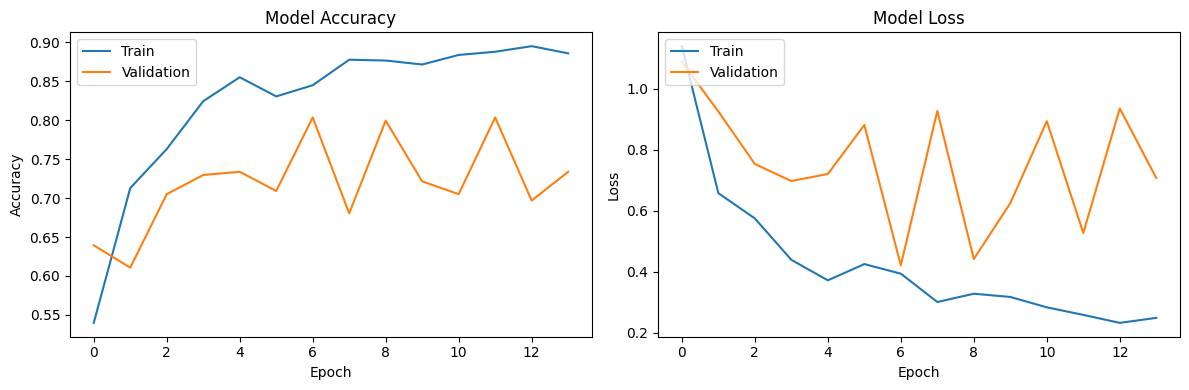

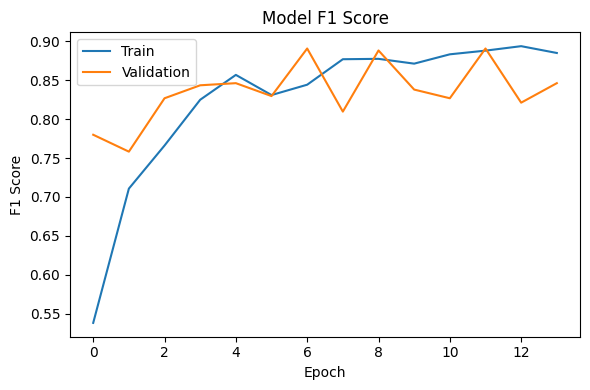

In [34]:
# Plot training history
plt.figure(figsize=(12, 4)) 
plt.subplot(1, 2, 1) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 

plt.subplot(1, 2, 2) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model Loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.tight_layout() 
plt.show() 

# Plot F1 Score if available 
if 'f1_score' in history.history: 
    plt.figure(figsize=(6, 4)) 
    plt.plot(history.history['f1_score']) 
    plt.plot(history.history['val_f1_score']) 
    plt.title('Model F1 Score') 
    plt.ylabel('F1 Score') 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Validation'], loc='upper left') 
    plt.tight_layout() 
    plt.show()


In [35]:
# Make predictions on test data
test_generator.reset() 
steps = int(np.ceil(len(test_generator.filenames)/BATCH_SIZE)) 
predictions = model.predict(test_generator, steps=steps) 

# Get the class labels
class_indices = {v: k for k, v in train_generator.class_indices.items()} 
predicted_classes = [class_indices[np.argmax(pred)] for pred in predictions] 

# Get the filenames that were processed
processed_filenames = [os.path.basename(filename) for filename in test_generator.filenames] 

# Create submission dataframe
submission_df = pd.DataFrame({ 
    'image_id': processed_filenames, 
    'soil_type': predicted_classes 
}) 

# Save submission file
submission_df.to_csv('soil_classification_submission.csv', index=False) 
print("Predictions saved to soil_classification_submission.csv")


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 574ms/step
Predictions saved to soil_classification_submission.csv


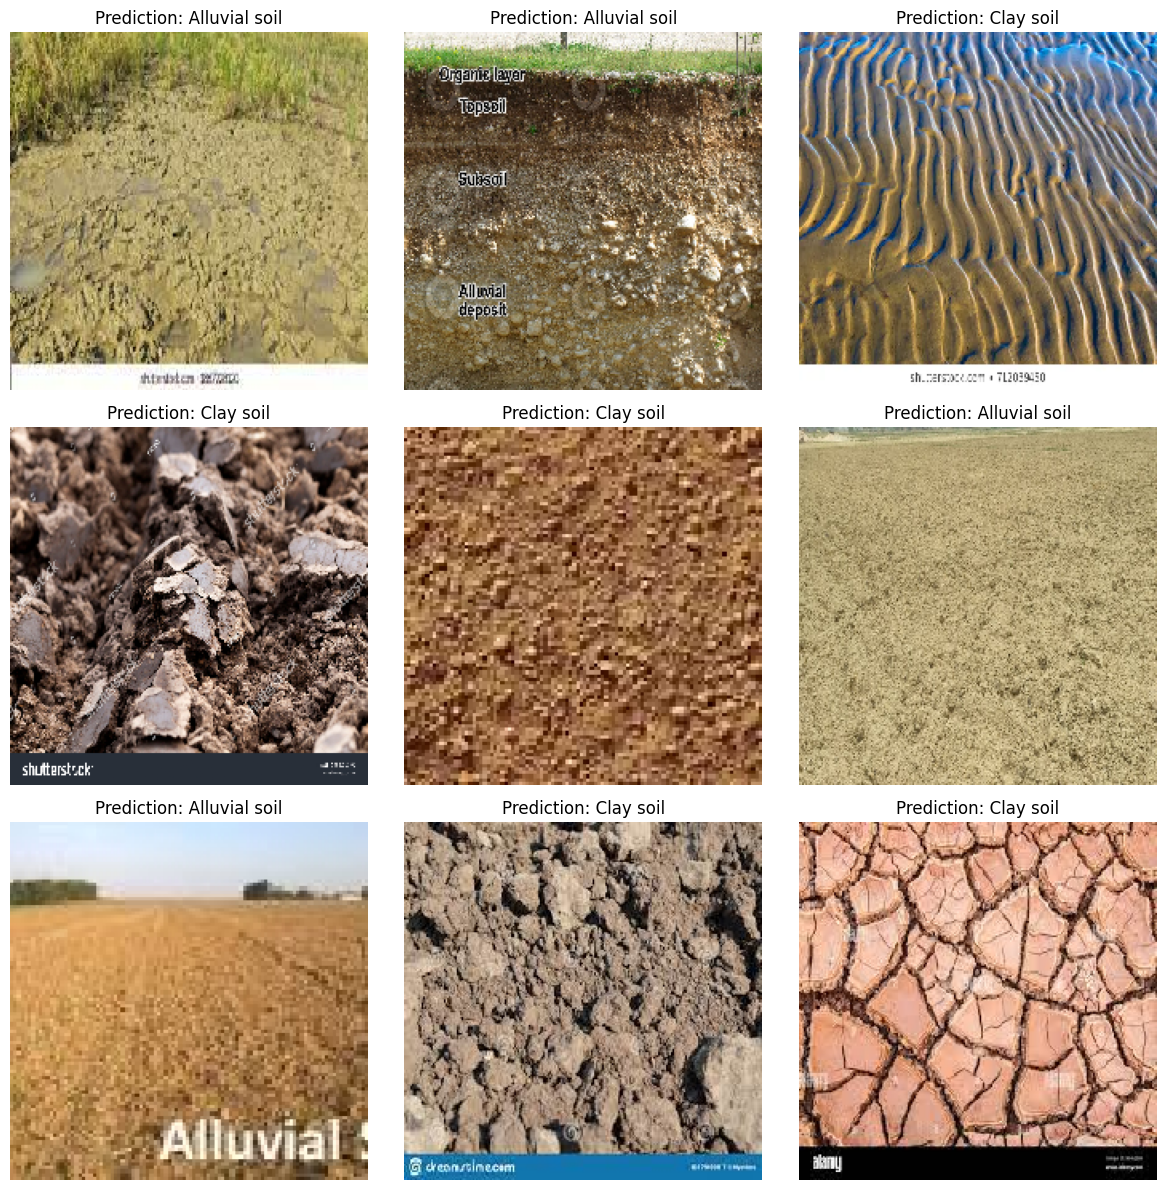

In [36]:
# Display some test predictions if test set has labels
if hasattr(test_generator, 'classes'):
    plt.figure(figsize=(12, 12))
    test_generator.reset()
    batch_x, batch_y = next(test_generator)
    
    for i in range(min(9, len(batch_x))):
        plt.subplot(3, 3, i+1)
        plt.imshow(batch_x[i])
        true_class = np.argmax(batch_y[i])
        pred_class = np.argmax(predictions[i])
        plt.title(f"True: {class_indices[true_class]}\nPred: {class_indices[pred_class]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    # If test set doesn't have labels, just show predictions
    plt.figure(figsize=(12, 12))
    test_generator.reset()
    batch_x = next(test_generator)
    
    for i in range(min(9, len(batch_x))):
        plt.subplot(3, 3, i+1)
        plt.imshow(batch_x[i])
        pred_class = np.argmax(predictions[i])
        plt.title(f"Prediction: {class_indices[pred_class]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [37]:
# Save the model
model.save('soil_classification_model.h5')
print("Model saved as soil_classification_model.h5")


Model saved as soil_classification_model.h5
